# Statistical Analysis & Hypothesis Testing — Indian Accident Dataset

**Goal:** Test whether accident **proportions** (by gender or age) differ significantly across **Type** (State vs UT vs City) and across regions.

**Methods:** Chi-square tests of independence, effect size (Cramér’s V), and confidence intervals for male share by region.

In [1]:
import subprocess
import sys

def ensure_package(pip_name, import_name=None):
    if import_name is None:
        import_name = pip_name
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

REQUIRED = [
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("scipy", "scipy"),
]
for pkg, imp in REQUIRED:
    ensure_package(pkg, imp)
print("All required libraries are available.")

All required libraries are available.


## 1. Load data and build core metrics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

sns.set_style("whitegrid")

# Load dataset
df = pd.read_csv("Dataset/Indian-Accident-Dataset.csv")
count_cols = [c for c in df.columns if c not in ['Type', 'Region']]

# Totals
df['Total_Accidents'] = df[count_cols].sum(axis=1)
male_cols = [c for c in count_cols if c.startswith('Male')]
female_cols = [c for c in count_cols if c.startswith('Female')]
df['Male_Total'] = df[male_cols].sum(axis=1)
df['Female_Total'] = df[female_cols].sum(axis=1)

# Age groups
age_groups = ['0-14', '14-18', '18-30', '30-45', '45-60', '60+']
for ag in age_groups:
    df[f'Age_{ag}'] = df[f'Male({ag})'] + df[f'Female({ag})']

print(df[['Type','Region','Total_Accidents','Male_Total','Female_Total']].head())

    Type             Region  Total_Accidents  Male_Total  Female_Total
0  State     Andhra Pradesh            16044       13517          2527
1  State  Arunachal Pradesh              391         340            51
2  State              Assam             4524        3706           818
3  State              Bihar            15405       11794          3611
4  State       Chhattisgarh            17522       13385          4137


## 2. Gender × Type — Chi-square test

In [3]:
# Contingency table: Type × Gender (counts)
gender_by_type = df.groupby('Type')[['Male_Total','Female_Total']].sum()

chi2, p, dof, expected = chi2_contingency(gender_by_type.values)

print("Gender × Type contingency (counts):")
print(gender_by_type)
print(f"\nChi-square: {chi2:.2f} | dof: {dof} | p-value: {p:.4g}")

Gender × Type contingency (counts):
       Male_Total  Female_Total
Type                           
City        43703          9783
State      318670         72318
UT           5521           988

Chi-square: 47.59 | dof: 2 | p-value: 4.628e-11


### Effect size: Cramér’s V

In [4]:
def cramers_v(table):
    chi2, _, _, _ = chi2_contingency(table)
    n = table.sum()
    r, k = table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

print(f"Cramér's V (Gender × Type): {cramers_v(gender_by_type.values):.4f}")

Cramér's V (Gender × Type): 0.0103


## 3. Age Group × Type — Chi-square test

In [5]:
# Contingency table: Type × Age group (counts)
age_cols = [f'Age_{ag}' for ag in age_groups]
age_by_type = df.groupby('Type')[age_cols].sum()

chi2, p, dof, expected = chi2_contingency(age_by_type.values)
print("Age group × Type contingency (counts):")
print(age_by_type)
print(f"\nChi-square: {chi2:.2f} | dof: {dof} | p-value: {p:.4g}")
print(f"Cramér's V (Age × Type): {cramers_v(age_by_type.values):.4f}")

Age group × Type contingency (counts):
       Age_0-14  Age_14-18  Age_18-30  Age_30-45  Age_45-60  Age_60+
Type                                                                
City       1687       1779      11605      16384      13925     8106
State     15300      23618      99350     120802      86947    44971
UT          210        272       1868       2123       1412      624

Chi-square: 1874.39 | dof: 10 | p-value: 0
Cramér's V (Age × Type): 0.0456


## 4. 18–30 vs 60+ by Type (proportions + test)

In [6]:
subset = df.groupby('Type')[['Age_18-30','Age_60+']].sum()
subset['Total'] = subset.sum(axis=1)
subset['Share_18_30'] = subset['Age_18-30'] / subset['Total']
subset['Share_60_plus'] = subset['Age_60+'] / subset['Total']
print(subset[['Share_18_30','Share_60_plus']])

chi2, p, dof, expected = chi2_contingency(subset[['Age_18-30','Age_60+']].values)
print(f"\nChi-square: {chi2:.2f} | dof: {dof} | p-value: {p:.4g}")

       Share_18_30  Share_60_plus
Type                             
City      0.588758       0.411242
State     0.688396       0.311604
UT        0.749599       0.250401

Chi-square: 848.18 | dof: 2 | p-value: 6.607e-185


## 5. Confidence intervals: Male share by region

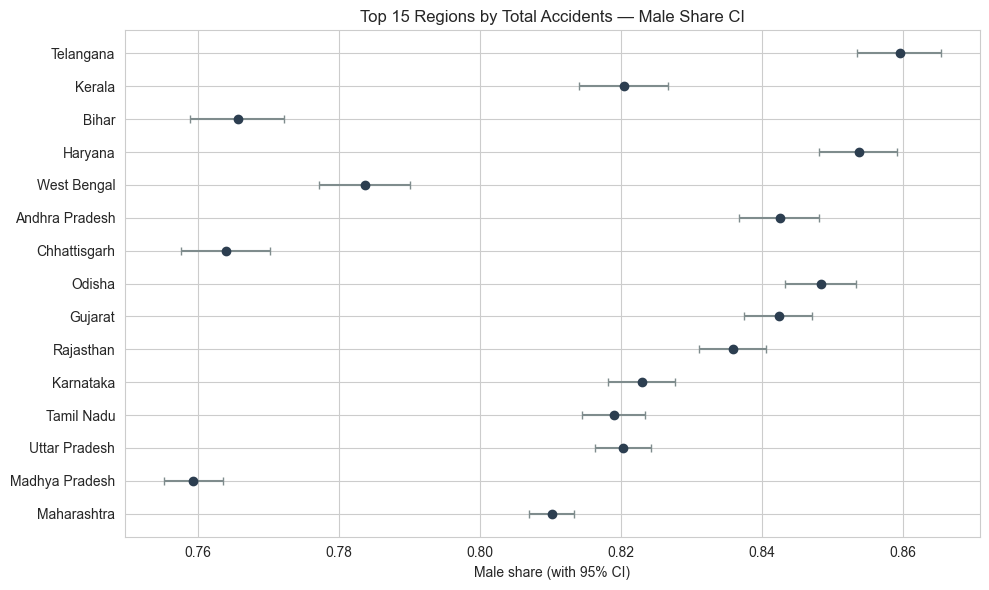

In [7]:
# Wilson score interval for proportions
from math import sqrt
from scipy.stats import norm

def wilson_ci(x, n, z=1.96):
    if n == 0:
        return (0, 0)
    p = x / n
    denom = 1 + (z**2 / n)
    center = (p + z**2 / (2*n)) / denom
    half = z * sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return center - half, center + half

# Compute male share and CI per region
ci_rows = []
for _, row in df.iterrows():
    n = row['Total_Accidents']
    x = row['Male_Total']
    low, high = wilson_ci(x, n)
    ci_rows.append((row['Type'], row['Region'], n, x/n if n else 0, low, high))

ci_df = pd.DataFrame(ci_rows, columns=['Type','Region','Total','Male_Share','CI_Low','CI_High'])
ci_df = ci_df.sort_values('Total', ascending=False)

# Show top 15 regions by total accidents with CIs
ci_top15 = ci_df.head(15)
ci_top15[['Region','Type','Total','Male_Share','CI_Low','CI_High']]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(ci_top15['Male_Share'], ci_top15['Region'],
            xerr=[ci_top15['Male_Share'] - ci_top15['CI_Low'], ci_top15['CI_High'] - ci_top15['Male_Share']],
            fmt='o', color='#2c3e50', ecolor='#7f8c8d', capsize=3)
ax.set_xlabel('Male share (with 95% CI)')
ax.set_title('Top 15 Regions by Total Accidents — Male Share CI')
plt.tight_layout()
plt.show()

## 6. Summary and interpretation

- **Gender × Type:** If p-value is small, gender distribution differs across States, UTs, and Cities. Cramér’s V gives the effect size.
- **Age × Type:** Tests whether age distribution differs across geographic types.
- **18–30 vs 60+:** Direct comparison of working-age vs senior share by type.
- **Male share CI:** Wide intervals indicate small-sample regions; narrow intervals indicate stable estimates.